In [10]:
import pandas as pd
from pathlib import Path

import os, sys
sys.path.append(os.path.abspath('..'))
from python_scripts.anomaly_detection import (
    detect_segment_anomalies,
    apply_clinical_flags,
    run_anomaly_and_clinical,
    SegmentAnomalyConfig,
    ClinicalThresholdConfig,
)

## Load Data

In [11]:
event_anom_df = pd.read_csv('../data/metrics/events.csv')

td_anom_df = pd.read_csv('../data/metrics/metrics.csv')

## Event Deviations Detection
* Detecting unsual events during walking session.
* This is to detect abnormal walking pattern compared with their own pattern.

In [12]:
event_anom_cfg = SegmentAnomalyConfig(
    features=(
        "contact_time_sec",
        "pti",
        "propulsion_index",
        "peak_load",
        "mean_load",
    ),
    z_threshold=3.5,
    min_segments_per_patient=3,
    top_k_reasons=3,
)

event_with_anom = detect_segment_anomalies(
    event_anom_df,
    config=event_anom_cfg
)

event_with_anom.sort_values(
    "anomaly_score",
    ascending=False
).head()

,patient_id,segment_id,event_id,start_time,end_time,contact_time_sec,mean_load,peak_load,load_var,pti,...,pti_lo,pti_hi,pti_direction,mean_load_lo,mean_load_hi,mean_load_direction,peak_load_lo,peak_load_hi,peak_load_direction,anom_reason_exp
304,62,0,4,2023-12-07 12:43:23.875,2023-12-07 12:43:24.235,0.360,0.143239,0.143239,0.000000,0.000000,...,0.000000,0.000000,within NORMAL range,0.141518,0.143239,within NORMAL range,0.141518,0.143239,within NORMAL range,"Duration of foot on the ground: 0.36 s, which ..."
303,62,0,3,2023-12-07 12:43:12.222,2023-12-07 12:43:12.573,0.351,0.143239,0.143239,0.000000,0.000000,...,0.000000,0.000000,within NORMAL range,0.141518,0.143239,within NORMAL range,0.141518,0.143239,within NORMAL range,"Duration of foot on the ground: 0.35 s, which ..."
655,226,0,2,2024-01-20 20:22:47.708,2024-01-20 20:22:48.427,0.719,0.736379,0.771906,0.001262,0.282518,...,0.196450,0.266689,HIGHER,0.589904,0.707126,HIGHER,0.602820,0.742345,HIGHER,The average pressure your foot experienced dur...
595,201,0,0,2024-01-20 18:17:38.969,2024-01-20 18:17:39.324,0.355,0.274582,0.274582,0.000000,0.000000,...,0.036284,0.268117,LOWER,0.269334,0.273534,HIGHER,0.273205,0.274582,within NORMAL range,The average pressure your foot experienced dur...
979,395,6,0,2024-07-04 09:00:00.429,2024-07-04 09:00:01.156,0.727,0.216360,0.303633,0.007616,0.047246,...,0.000000,0.028936,HIGHER,0.197633,0.453658,within NORMAL range,0.276505,0.453658,within NORMAL range,PTI (Pressure + duration of contact): 0.05 was...


## Save Data

In [13]:
out = Path('../data/anomaly')
out.mkdir(parents=True, exist_ok=True)

In [14]:
event_with_anom.to_csv(out / 'event_anomalies.csv', index=False)
print('Saved event_anomalies.csv')

Saved event_anomalies.csv


## Visualisation

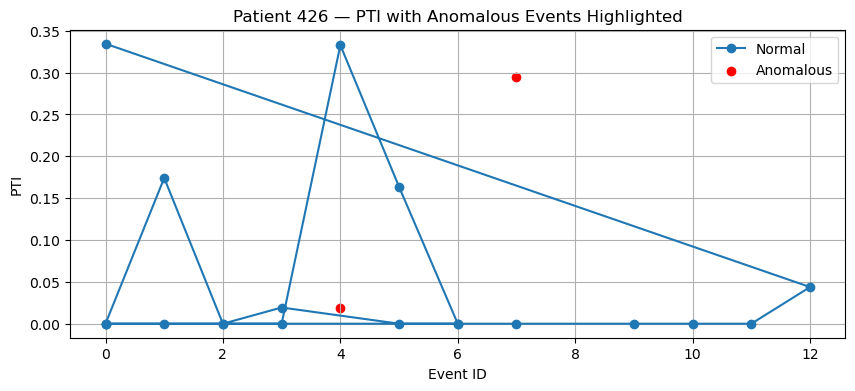

In [ ]:
import matplotlib.pyplot as plt


anom = pd.read_csv("../data/anomaly/event_anomalies.csv")
pid = 426
ev = anom[anom["patient_id"] == pid].copy()


plt.figure(figsize=(10,4))

normal = ev[~ev["is_segment_anomaly"]]
bad = ev[ev["is_segment_anomaly"]]

plt.plot(normal["event_id"], normal["pti"], marker="o", label="Normal")
plt.scatter(bad["event_id"], bad["pti"], color="red", label="Anomalous")

plt.title(f"Patient {pid} — PTI with Anomalous Events Highlighted")
plt.xlabel("Event ID")
plt.ylabel("PTI")
plt.legend()
plt.grid(True)

out_path = f"../figures/id_{pid}_anomalous_events.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

## Threshold-based clinical flags
* These threshold anomalies are detected whether a metric is outside of a clinical accepted thresholds (normal range) or within.
* These thresholds are not assumptions but referenced by publised literatures.

In [16]:
clinical_cfg = ClinicalThresholdConfig(
    thresholds={
        'cadence_spm_low': 40.0,
        'cadence_spm_high': 150.0,
        'step_interval_cv_high': 0.50,
        'temp_mean_low': 25.0,
        'mean_contact_low': 0.40,
        'mean_contact_high': 1.30,
        'stance_pct_low': 55.0,
        'stance_pct_high': 65.0,
    }
)

segment_with_flags = apply_clinical_flags(
    td_anom_df,
    config=clinical_cfg
)

segment_with_flags[segment_with_flags["clinical_flag"]].head()

segment_with_flags.to_csv(out / 'segment_flags.csv', index=False)
print('Saved segment_flags.csv')

Saved segment_flags.csv


In [17]:
combined = run_anomaly_and_clinical(
    segment_with_flags,
    anomaly_config=event_anom_cfg,
    clinical_config=clinical_cfg
)